In [138]:
import torch
from torch import nn,optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torchvision import transforms as tt
from torch.utils.data import DataLoader,random_split
from torchvision.utils import make_grid
from torchvision.datasets import ImageFolder
import os

In [139]:
path='/kaggle/input/realwaste/realwaste-main/RealWaste'

In [140]:
dataset=ImageFolder(path)

In [ ]:
img,label=dataset[0]
plt.imshow(img)

In [ ]:
stats=([0.485,0.456,0.406],[0.229,0.224,0.225])
dataset=ImageFolder(path,tt.Compose([tt.Resize(64),
                                    tt.RandomCrop(64),
                                    tt.RandomHorizontalFlip(),
                                    tt.RandomRotation(10),
                                    tt.ToTensor(),
                                    tt.Normalize(*stats)]))

In [ ]:
val_pct=0.2
val_size=int(val_pct*len(dataset))
train_size=len(dataset)-val_size

train_size,val_size

In [ ]:
from torch.utils.data import random_split

train_ds,valid_ds=random_split(dataset,[train_size,val_size])
len(train_ds),len(valid_ds)

In [ ]:
batch_size=128
train_dl=DataLoader(train_ds,batch_size,shuffle=True,pin_memory=True)
valid_dl=DataLoader(valid_ds,batch_size,shuffle=True,pin_memory=True)

In [ ]:
classes=dataset.classes
classes

In [145]:
def denormalize(images, means, stds):
    if len(images.shape) == 3:
        images = images.unsqueeze(0)
    means = torch.tensor(means).reshape(1, 3, 1, 1)
    stds = torch.tensor(stds).reshape(1, 3, 1, 1)
    return images * stds + means

def show_image(img_tensor, label):
    print('Label: ', dataset.classes[label], '(', str(label), ')')
    img_tensor = denormalize(img_tensor, *stats)[0].permute((1, 2, 0))
    plt.imshow(img_tensor)

Label:  Glass ( 2 )


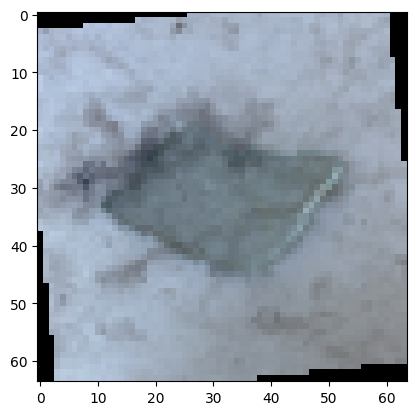

In [146]:
img,label=train_ds[1]
show_image(img,label)

In [147]:
def get_default_device():
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

def to_device(data,device):
    if isinstance(data,(list,tuple)):
        return [to_device(x,device) for x in data]
    return data.to(device,non_blocking=True)

class DeviceDataLoader():
    def __init__(self,dl,device):
        self.dl=dl
        self.device=device
    
    def __iter__(self):
        for b in self.dl:
            yield to_device(b,self.device)
            
    def __len__(self):
        return len(self.dl)

In [148]:
device=get_default_device()
device

device(type='cuda')

In [149]:
train_dl=DeviceDataLoader(train_dl,device)
valid_dl=DeviceDataLoader(valid_dl,device)

In [150]:
# Helper function to calculate accuracy
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

# Base class for image classification models
class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch
        out = self(images)
        loss = F.cross_entropy(out, labels)
        acc = accuracy(out, labels)  # Calculate training accuracy
        return loss, acc

    def validation_step(self, batch):
        images, labels = batch
        out = self(images)
        loss = F.cross_entropy(out, labels)
        acc = accuracy(out, labels)
        return {'val_loss': loss.detach(), 'val_acc': acc}

    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}

    def epoch_end(self, epoch, result):
        lr = result.get('lr', [0.0])
        train_loss = result.get('train_loss', 0.0)
        val_loss = result.get('val_loss', 0.0)
        val_acc = result.get('val_acc', 0.0)
        train_acc = result.get('train_acc', 0.0)  # Add train_acc

        if isinstance(lr, list):
            lr = lr[-1]

        print(f"Epoch [{epoch}], "
              f"train_loss: {train_loss:.4f}, train_acc: {train_acc:.4f}, "
              f"val_loss: {val_loss:.4f}, val_acc: {val_acc:.4f}")


In [151]:
def conv_block(in_channels,out_channels,pool=False):
    layers=[nn.Conv2d(in_channels,out_channels,kernel_size=3,padding=1),
           nn.BatchNorm2d(out_channels),
           nn.ReLU(inplace=True)]
    if pool:
        layers.append(nn.MaxPool2d(2))
    return nn.Sequential(*layers)

In [152]:
class Waste(ImageClassificationBase):
    
    def __init__(self,in_channels,num_classes):
        super().__init__()
        
        self.conv1=conv_block(in_channels,64)
        self.conv2=conv_block(64,128,pool=True)
        self.res1=nn.Sequential(conv_block(128,128),conv_block(128,128))
        
        self.conv3=conv_block(128,256,pool=True)
        self.conv4=conv_block(256,512,pool=True)
        self.res2=nn.Sequential(conv_block(512,512),conv_block(512,512))
        
        self.classifier=nn.Sequential(nn.AdaptiveMaxPool2d(1),
                                     nn.Flatten(),
                                     nn.Dropout(0.2),
                                     nn.Linear(512,num_classes))
        
    def forward(self,xb):
        out=self.conv1(xb)
        out=self.conv2(out)
        out=self.res1(out)+out
        out=self.conv3(out)
        out=self.conv4(out)
        out=self.res2(out)+out
        out=self.classifier(out)
        return out

In [153]:
def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

# Evaluate the model on the validation set
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

# Training loop with one-cycle learning rate scheduling
def fit_one_cycle(epochs, max_lr, model, train_loader, val_loader, weight_decay=0, grad_clip=None, opt_func=optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), max_lr, weight_decay=weight_decay)
    sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs, steps_per_epoch=len(train_loader))
    
    for epoch in range(epochs):
        model.train()
        train_losses = []
        train_accs = []  # Track training accuracy
        lrs = []
        for batch in train_loader:
            loss, acc = model.training_step(batch)  # Get loss and accuracy
            train_losses.append(loss)
            train_accs.append(acc)  # Store accuracy
            loss.backward()
            
            if grad_clip:
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)
            
            optimizer.step()
            optimizer.zero_grad()
            
            lrs.append(get_lr(optimizer))
            sched.step()
            
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        result['train_acc'] = torch.stack(train_accs).mean().item()  # Calculate mean training accuracy
        result['lr'] = lrs
        model.epoch_end(epoch, result)
        history.append(result)
            
    return history

In [154]:
model=to_device(Waste(3,len(classes)),device)
model

Waste(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (res1): Sequential(
    (0): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True

In [155]:
for batch in train_dl:
    images,labels=batch
    print('images.shape',images.shape)
    print('images.device',images.device)
    preds=model(images)
    print('preds.shape',preds.shape)
    break

images.shape torch.Size([128, 3, 64, 64])
images.device cuda:0
preds.shape torch.Size([128, 9])


In [156]:
history=[evaluate(model,valid_dl)]
history

[{'val_loss': 2.1955554485321045, 'val_acc': 0.1780598908662796}]

In [157]:
history+=fit_one_cycle(20,0.001,model,train_dl,valid_dl,weight_decay=1e-4,grad_clip=0.1,opt_func=torch.optim.Adam)

Epoch [0], train_loss: 2.3124, train_acc: 0.2895, val_loss: 1.8790, val_acc: 0.3337
Epoch [1], train_loss: 1.5614, train_acc: 0.4819, val_loss: 1.2711, val_acc: 0.5356
Epoch [2], train_loss: 1.3529, train_acc: 0.5364, val_loss: 1.8614, val_acc: 0.4556
Epoch [3], train_loss: 1.1881, train_acc: 0.5892, val_loss: 1.5107, val_acc: 0.5234
Epoch [4], train_loss: 1.1149, train_acc: 0.6140, val_loss: 0.9494, val_acc: 0.6516
Epoch [5], train_loss: 0.9540, train_acc: 0.6620, val_loss: 1.4298, val_acc: 0.5348
Epoch [6], train_loss: 0.8992, train_acc: 0.6859, val_loss: 1.4301, val_acc: 0.5764
Epoch [7], train_loss: 0.8256, train_acc: 0.7062, val_loss: 1.0833, val_acc: 0.6544
Epoch [8], train_loss: 0.7071, train_acc: 0.7450, val_loss: 0.7257, val_acc: 0.7397
Epoch [9], train_loss: 0.6463, train_acc: 0.7682, val_loss: 0.8225, val_acc: 0.7023
Epoch [10], train_loss: 0.5800, train_acc: 0.7956, val_loss: 0.8175, val_acc: 0.7189
Epoch [11], train_loss: 0.5081, train_acc: 0.8157, val_loss: 0.5700, val_ac

In [158]:
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. Epoch')

def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['train', 'valid'])
    plt.title('Loss vs. Epoch')
    
def predict_image(img, model, classes):
    xb = to_device(img.unsqueeze(0), device)
    yb = model(xb)
    _, preds = torch.max(yb, dim=1)
    return classes[preds[0].item()]

def predict(index, dataset, model, classes):
    img, label = dataset[index]
    show_image(img, label)
    pred = predict_image(img, model, classes)
    print('Predicted: ', pred)

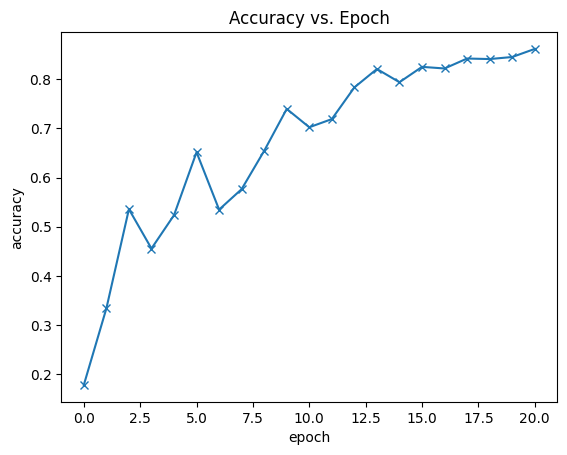

In [159]:
plot_accuracies(history)

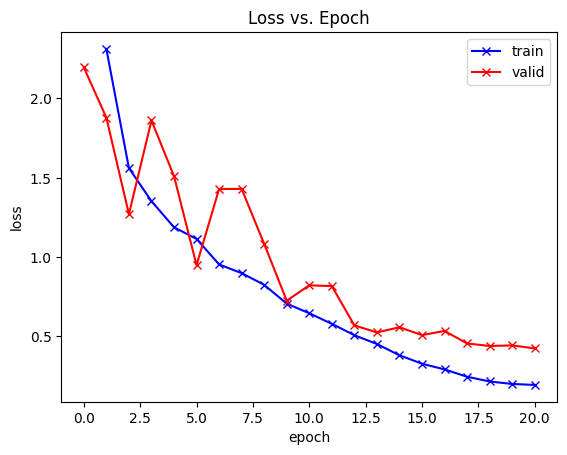

In [160]:
plot_losses(history)

Label:  Food Organics ( 1 )
Predicted:  Food Organics


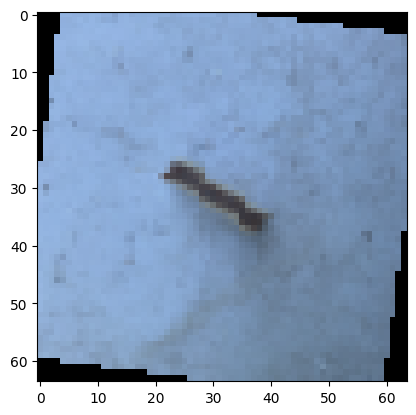

In [161]:
predict(1,valid_ds,model,classes)

Label:  Metal ( 3 )
Predicted:  Plastic


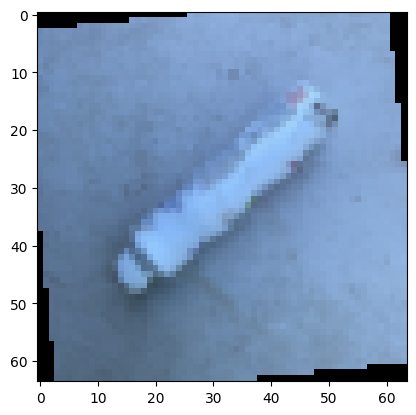

In [162]:
predict(10,valid_ds,model,classes)

Label:  Metal ( 3 )
Predicted:  Metal


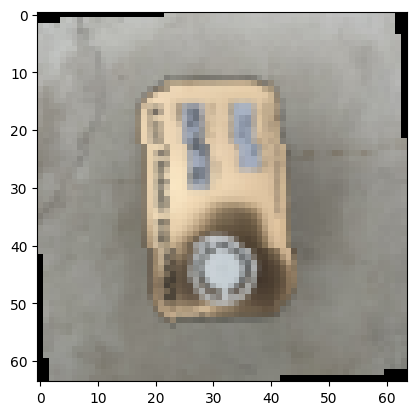

In [163]:
predict(11,valid_ds,model,classes)

Label:  Plastic ( 6 )
Predicted:  Plastic


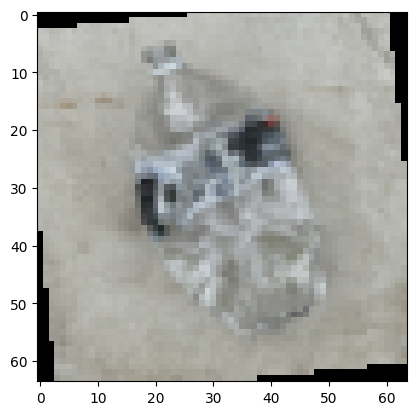

In [164]:
predict(20,valid_ds,model,classes)

Label:  Metal ( 3 )
Predicted:  Metal


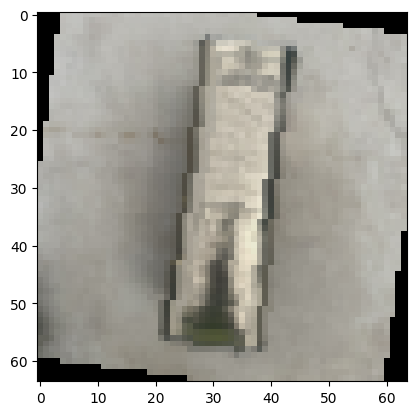

In [165]:
predict(21,valid_ds,model,classes)

Label:  Paper ( 5 )
Predicted:  Paper


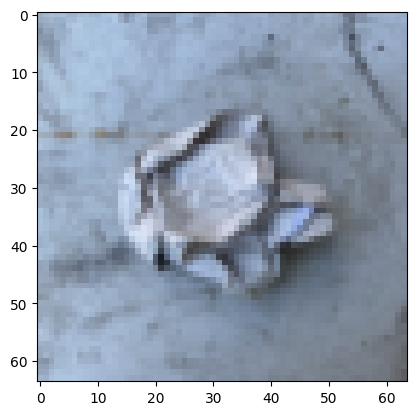

In [166]:
predict(30,valid_ds,model,classes)

Label:  Plastic ( 6 )
Predicted:  Plastic


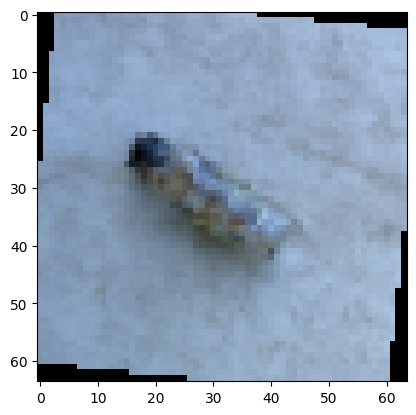

In [168]:
predict(900,valid_ds,model,classes)

Label:  Cardboard ( 0 )
Predicted:  Cardboard


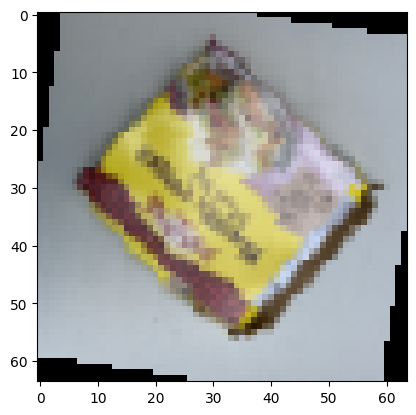

In [170]:
predict(949,valid_ds,model,classes)

Label:  Food Organics ( 1 )
Predicted:  Food Organics


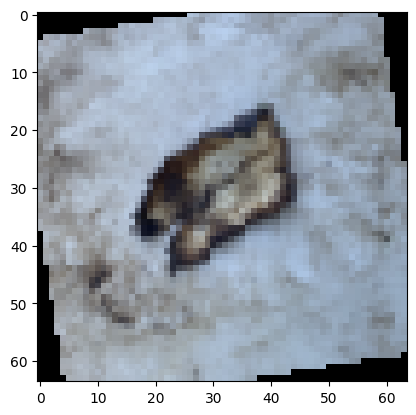

In [171]:
predict(800,valid_ds,model,classes)